# Scientific Benchmark: DINOv2 Pipeline Configuration Comparison

**Goal:** Find the optimal configuration for vehicle detection using DINOv2 features.

## Configurations Tested:

| Parameter | Options |
|-----------|--------|
| Reference Image | WITH background, WITHOUT background |
| Similarity Map Blur | None, Gaussian (σ=1,2,3,5) |
| Threshold | 0.1, 0.2, 0.3, 0.4, 0.5 |
| Morphological Ops | None, Erosion, Dilation, Opening, Closing |

**Metrics:** IoU, Precision, Recall, F1-Score

**Dataset:** UrbanSyn RGB images with panoptic ground truth masks

In [2]:
# Imports
import numpy as np
import torch
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from itertools import product
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# === Diagnostics ===
print("="*50)
print("ENVIRONMENT CHECK")
print("="*50)
print(f"NumPy:   {np.__version__}", end="")
print(" ✓" if int(np.__version__.split('.')[0]) < 2 else " ⚠ (v2.x may cause issues)")
print(f"PyTorch: {torch.__version__}")
print(f"OpenCV:  {cv2.__version__}")

# Check CUDA
if torch.cuda.is_available():
    print(f"CUDA:    {torch.version.cuda} ✓")
    print(f"GPU:     {torch.cuda.get_device_name(0)}")
    _device = "cuda"
else:
    print("CUDA:    Not available ⚠")
    print("         (Install: pip install torch --index-url https://download.pytorch.org/whl/cu121)")
    _device = "cpu"

print(f"\nUsing device: {_device}")

# Test NumPy-PyTorch bridge
try:
    test = torch.from_numpy(np.array([1.0], dtype=np.float32))
    print("NumPy↔PyTorch: Working ✓")
except RuntimeError as e:
    print(f"NumPy↔PyTorch: BROKEN ⚠ - {e}")
    print("         Run the setup cell and restart kernel!")
print("="*50)

ENVIRONMENT CHECK
NumPy:   1.26.4 ✓
PyTorch: 2.5.1+cu121
OpenCV:  4.11.0
CUDA:    12.1 ✓
GPU:     NVIDIA GeForce RTX 3070 Ti Laptop GPU

Using device: cuda
NumPy↔PyTorch: Working ✓


In [109]:
# Load DINOv2 Model
print("Loading DINOv2...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').eval().to(_device)

def pil_to_tensor(img):
    """Convert PIL Image to normalized tensor."""
    img = img.convert('RGB').resize((518, 518), Image.BILINEAR)
    img_data = list(img.getdata())
    h, w = img.size
    r = torch.tensor([p[0] for p in img_data], dtype=torch.float32).view(w, h) / 255.0
    g = torch.tensor([p[1] for p in img_data], dtype=torch.float32).view(w, h) / 255.0
    b = torch.tensor([p[2] for p in img_data], dtype=torch.float32).view(w, h) / 255.0
    img_tensor = torch.stack([r, g, b], dim=0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor - mean) / std

print("Model loaded!")

Loading DINOv2...


Using cache found in /app/models/hub/facebookresearch_dinov2_main


Model loaded!


In [ ]:
# Core Functions
from scipy.ndimage import zoom

def extract_global_feature(model, img_tensor, device):
    with torch.no_grad():
        return model(img_tensor.to(device))

def extract_patch_features(model, img_tensor, device):
    with torch.no_grad():
        features = model.forward_features(img_tensor.to(device))
        return features['x_norm_patchtokens']

def tensor_to_numpy(t):
    """Convert tensor to numpy, handling compatibility issues."""
    t = t.detach().cpu()
    # Use storage-based conversion as fallback
    shape = tuple(t.shape)
    flat = [t.flatten()[i].item() for i in range(t.numel())]
    return np.array(flat, dtype=np.float32).reshape(shape)

def compute_similarity_map(global_feat, patch_feat):
    global_norm = F.normalize(global_feat, p=2, dim=1)
    patch_norm = F.normalize(patch_feat, p=2, dim=2)
    sim = torch.matmul(patch_norm, global_norm.T).squeeze()
    return tensor_to_numpy(sim.reshape(37, 37))

def upscale_mask(mask, target_size):
    """Upscale mask using scipy zoom (pure numpy, no torch)."""
    mask = np.asarray(mask, dtype=np.float32)
    zoom_factors = (target_size[0] / mask.shape[0], target_size[1] / mask.shape[1])
    return zoom(mask, zoom_factors, order=1)  # order=1 = bilinear

def compute_metrics(pred, gt):
    # Ensure numpy arrays
    pred = np.asarray(pred, dtype=np.float32)
    gt = np.asarray(gt, dtype=np.float32)
    
    pred_b = (pred > 0.5).astype(np.float32)
    gt_b = (gt > 0.5).astype(np.float32)
    
    intersection = np.logical_and(pred_b, gt_b).sum()
    union = np.logical_or(pred_b, gt_b).sum()
    
    tp = intersection
    fp = np.logical_and(pred_b, ~gt_b.astype(bool)).sum()
    fn = np.logical_and(~pred_b.astype(bool), gt_b.astype(bool)).sum()
    
    iou = tp / union if union > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {'iou': iou, 'precision': precision, 'recall': recall, 'f1': f1}

def load_car_mask(panoptic_path):
    """Load ground truth car mask (color #d2c310 = RGB 210, 195, 16)."""
    panoptic = np.array(Image.open(panoptic_path))
    CAR_COLOR = (210, 195, 16)
    if len(panoptic.shape) == 3:
        mask = ((panoptic[:,:,0] == CAR_COLOR[0]) & 
                (panoptic[:,:,1] == CAR_COLOR[1]) & 
                (panoptic[:,:,2] == CAR_COLOR[2])).astype(np.float32)
    else:
        mask = np.zeros_like(panoptic, dtype=np.float32)
    return mask

print("Functions loaded!")

Functions loaded!


In [ ]:
# Blur and Morphological Operations

def apply_blur(sim_map, blur_sigma):
    """Apply Gaussian blur to similarity map."""
    if blur_sigma == 0:
        return sim_map
    sim_map = np.asarray(sim_map, dtype=np.float32)
    ksize = int(blur_sigma * 4) | 1  # Make odd
    ksize = max(3, ksize)
    return cv2.GaussianBlur(sim_map, (ksize, ksize), blur_sigma)

def apply_morphology(mask, operation, kernel_size=5):
    """Apply morphological operation to binary mask."""
    if operation == 'none':
        return mask
    
    # Ensure contiguous numpy array
    mask = np.ascontiguousarray(mask, dtype=np.float32)
    
    # Create kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Convert to uint8 for OpenCV
    mask_uint8 = np.ascontiguousarray((mask * 255).astype(np.uint8))
    
    if operation == 'erosion':
        result = cv2.erode(mask_uint8, kernel, iterations=1)
    elif operation == 'dilation':
        result = cv2.dilate(mask_uint8, kernel, iterations=1)
    elif operation == 'opening':  # Erosion followed by Dilation (removes noise)
        result = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':  # Dilation followed by Erosion (fills holes)
        result = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    else:
        return mask
    
    return (result / 255.0).astype(np.float32)

print("Blur and morphological operations loaded:")
print("  - erosion: Shrinks foreground (removes small objects)")
print("  - dilation: Expands foreground (fills small holes)")
print("  - opening: Erosion + Dilation (removes noise)")
print("  - closing: Dilation + Erosion (fills gaps)")

Blur and morphological operations loaded:
  - erosion: Shrinks foreground (removes small objects)
  - dilation: Expands foreground (fills small holes)
  - opening: Erosion + Dilation (removes noise)
  - closing: Dilation + Erosion (fills gaps)


In [ ]:
# Load Reference Images and Dataset
REF_DIR = 'ref_car'
RGB_DIR = 'urbansyn_subset/rgb'
PANOPTIC_DIR = 'panoptic'

# Reference images
ref_bg_img = Image.open(os.path.join(REF_DIR, 'ref_car_BG.png')).convert('RGB')
ref_nbg_img = Image.open(os.path.join(REF_DIR, 'ref_car_NBG.jpg')).convert('RGB')

# Extract reference features
print("Extracting reference features...")
ref_bg_tensor = pil_to_tensor(ref_bg_img).unsqueeze(0).to(_device)
ref_nbg_tensor = pil_to_tensor(ref_nbg_img).unsqueeze(0).to(_device)

ref_bg_feat = extract_global_feature(model, ref_bg_tensor, _device)
ref_nbg_feat = extract_global_feature(model, ref_nbg_tensor, _device)

# Load image pairs (RGB + panoptic)
rgb_files = sorted(glob(os.path.join(RGB_DIR, 'rgb_*.png')))[:100]  # First 100
image_pairs = []
for rgb_path in rgb_files:
    num = os.path.basename(rgb_path).replace('rgb_', '').replace('.png', '')
    panoptic_path = os.path.join(PANOPTIC_DIR, f'panoptic_{num}.png')
    if os.path.exists(panoptic_path):
        gt_mask = load_car_mask(panoptic_path)
        if gt_mask.sum() > 500:  # Only images with cars
            image_pairs.append((rgb_path, panoptic_path))

print(f"Reference images loaded")
print(f"Found {len(image_pairs)} images with cars (>500 GT pixels)")

Extracting reference features...
Reference images loaded
Found 14 images with cars (>500 GT pixels)


In [ ]:
# Define Configuration Space

CONFIGS = {
    'reference': ['BG', 'NBG'],           # With/without background
    'blur_sigma': [0, 0.25, 0.5, 0.75, 1, 2],  # Finer blur values to test soft blur
    'threshold': [0.1, 0.2, 0.3, 0.4, 0.5],  # Similarity threshold
    'morphology': ['none', 'erosion', 'dilation', 'opening', 'closing'],  # Post-processing
}

# Calculate total configurations
total_configs = 1
for k, v in CONFIGS.items():
    total_configs *= len(v)
    print(f"{k}: {len(v)} options - {v}")

print(f"\nTotal configurations to test: {total_configs}")
print(f"Images per config: {len(image_pairs)}")
print(f"Total evaluations: {total_configs * len(image_pairs)}")

reference: 2 options - ['BG', 'NBG']
blur_sigma: 6 options - [0, 0.25, 0.5, 0.75, 1, 2]
threshold: 5 options - [0.1, 0.2, 0.3, 0.4, 0.5]
morphology: 5 options - ['none', 'erosion', 'dilation', 'opening', 'closing']

Total configurations to test: 300
Images per config: 14
Total evaluations: 4200


In [ ]:
# Run Comprehensive Benchmark
import numpy as np
results = []

# Pre-compute similarity maps for all images (saves time)
print("Pre-computing similarity maps...")
sim_maps_cache = {}

for rgb_path, panoptic_path in tqdm(image_pairs, desc="Computing features"):
    rgb_img = Image.open(rgb_path).convert('RGB')
    rgb_tensor = pil_to_tensor(rgb_img).unsqueeze(0).to(_device)
    patch_feat = extract_patch_features(model, rgb_tensor, _device)
    
    sim_maps_cache[rgb_path] = {
        'BG': compute_similarity_map(ref_bg_feat, patch_feat),
        'NBG': compute_similarity_map(ref_nbg_feat, patch_feat),
        'gt_mask': load_car_mask(panoptic_path)
    }

print(f"Cached {len(sim_maps_cache)} similarity maps")

# Test all configurations
print("\nRunning benchmark...")
all_configs = list(product(
    CONFIGS['reference'],
    CONFIGS['blur_sigma'],
    CONFIGS['threshold'],
    CONFIGS['morphology']
))

for ref_type, blur_sigma, threshold, morph_op in tqdm(all_configs, desc="Testing configs"):
    config_metrics = []
    
    for rgb_path in sim_maps_cache.keys():
        cache = sim_maps_cache[rgb_path]
        sim_map = cache[ref_type].copy()
        gt_mask = cache['gt_mask']
        
        # Apply blur
        sim_map_blurred = apply_blur(sim_map, blur_sigma)
        
        # Apply threshold
        pred_mask_small = (sim_map_blurred >= threshold).astype(np.float32)
        
        # Upscale to GT size
        pred_mask = upscale_mask(pred_mask_small, gt_mask.shape)
        
        # Apply morphology
        pred_mask = apply_morphology(pred_mask, morph_op, kernel_size=5)
        
        # Compute metrics
        metrics = compute_metrics(pred_mask, gt_mask)
        config_metrics.append(metrics)
    
    # Average metrics for this config
    avg_metrics = {
        'reference': ref_type,
        'blur_sigma': blur_sigma,
        'threshold': threshold,
        'morphology': morph_op,
        'iou': np.mean([m['iou'] for m in config_metrics]),
        'precision': np.mean([m['precision'] for m in config_metrics]),
        'recall': np.mean([m['recall'] for m in config_metrics]),
        'f1': np.mean([m['f1'] for m in config_metrics]),
    }
    results.append(avg_metrics)

print(f"\nCompleted {len(results)} configurations!")

Pre-computing similarity maps...


Computing features: 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]


Cached 14 similarity maps

Running benchmark...


Testing configs: 100%|██████████| 300/300 [03:55<00:00,  1.27it/s]


Completed 300 configurations!


In [ ]:
# Convert to DataFrame and analyze
df = pd.DataFrame(results)

# Sort by IoU (primary metric)
df_sorted = df.sort_values('iou', ascending=False)

print("="*80)
print("TOP 20 CONFIGURATIONS (sorted by IoU)")
print("="*80)
print(df_sorted.head(20).to_string(index=False))

print("\n" + "="*80)
print("BOTTOM 10 CONFIGURATIONS")
print("="*80)
print(df_sorted.tail(10).to_string(index=False))

TOP 20 CONFIGURATIONS (sorted by IoU)
reference  blur_sigma  threshold morphology      iou  precision   recall       f1
      NBG        0.50        0.4    erosion 0.713018   0.812129 0.813840 0.803000
      NBG        0.75        0.4   dilation 0.711752   0.817694 0.808639 0.802434
      NBG        0.75        0.4    closing 0.711597   0.829922 0.796552 0.801792
      NBG        0.75        0.4    opening 0.711593   0.829937 0.796542 0.801789
      NBG        0.75        0.4       none 0.711533   0.829401 0.796938 0.801765
      NBG        0.50        0.4    opening 0.711049   0.798300 0.825858 0.802215
      NBG        0.50        0.4    closing 0.711042   0.798280 0.825872 0.802212
      NBG        0.50        0.4       none 0.710937   0.797743 0.826286 0.802169
      NBG        0.75        0.4    erosion 0.709773   0.841575 0.783484 0.799958
      NBG        0.00        0.4    erosion 0.707662   0.841033 0.841041 0.809432
      NBG        0.25        0.4    erosion 0.707662   0.841

In [ ]:
# Best Configuration Analysis
best = df_sorted.iloc[0]

print("="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"Reference:    {best['reference']} (WITH background)" if best['reference'] == 'BG' else f"Reference:    {best['reference']} (WITHOUT background)")
print(f"Blur Sigma:   {best['blur_sigma']}" + (" (no blur)" if best['blur_sigma'] == 0 else ""))
print(f"Threshold:    {best['threshold']}")
print(f"Morphology:   {best['morphology']}")
print(f"")
print(f"IoU:          {best['iou']:.4f}")
print(f"Precision:    {best['precision']:.4f}")
print(f"Recall:       {best['recall']:.4f}")
print(f"F1-Score:     {best['f1']:.4f}")
print("="*60)

BEST CONFIGURATION
Reference:    NBG (WITHOUT background)
Blur Sigma:   0.5
Threshold:    0.4
Morphology:   erosion

IoU:          0.7130
Precision:    0.8121
Recall:       0.8138
F1-Score:     0.8030


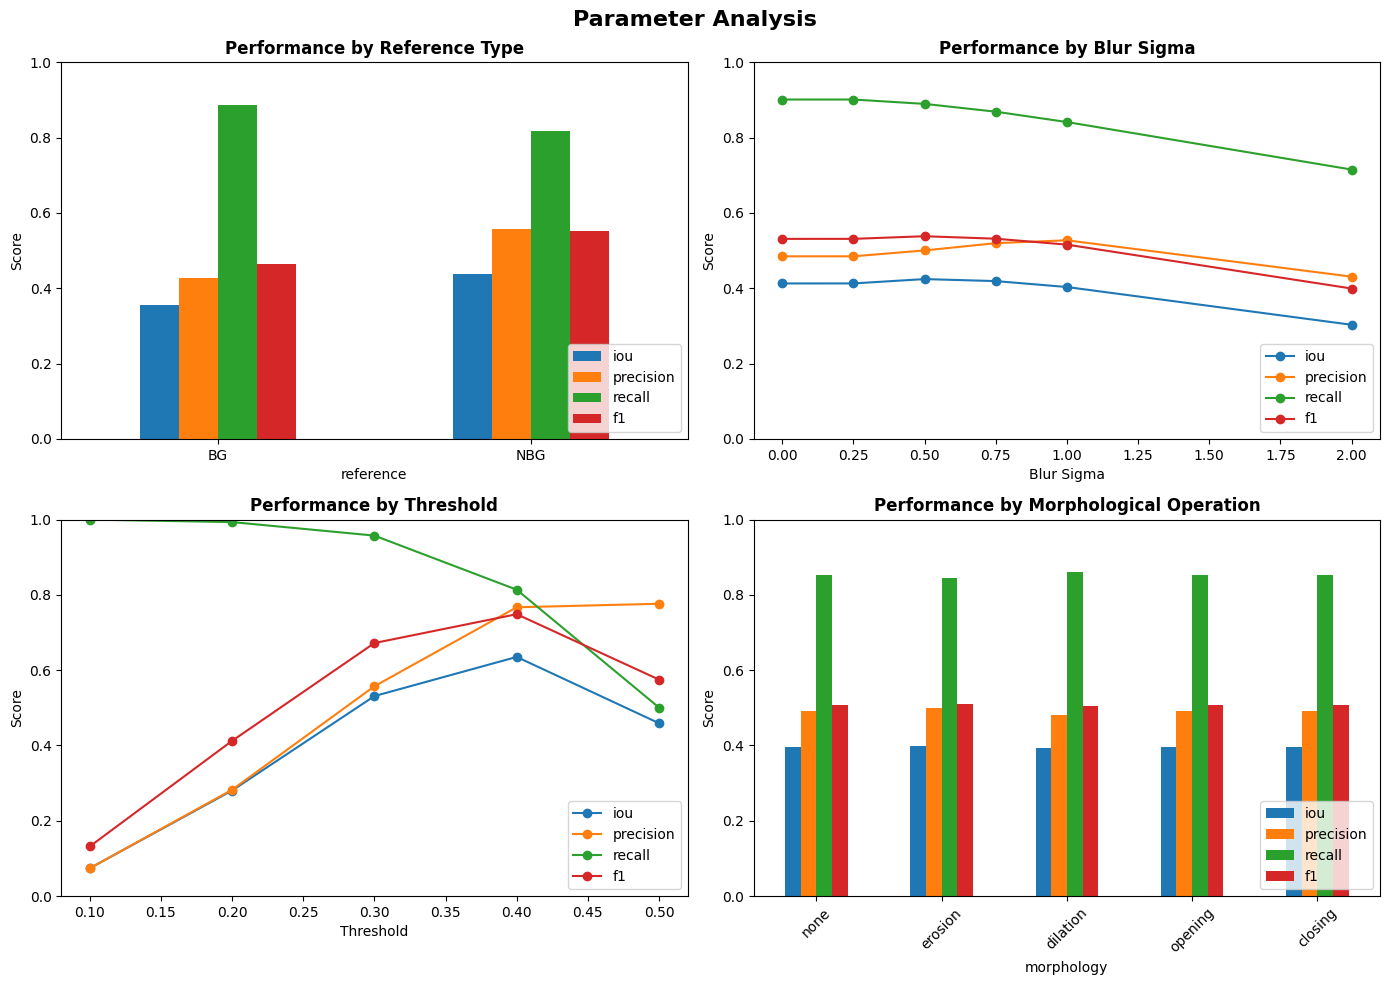

In [ ]:
# Analysis by Parameter

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Reference: BG vs NBG
ax = axes[0, 0]
ref_analysis = df.groupby('reference')[['iou', 'precision', 'recall', 'f1']].mean()
ref_analysis.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Performance by Reference Type', fontweight='bold')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# 2. Blur Sigma
ax = axes[0, 1]
blur_analysis = df.groupby('blur_sigma')[['iou', 'precision', 'recall', 'f1']].mean()
blur_analysis.plot(kind='line', ax=ax, marker='o')
ax.set_title('Performance by Blur Sigma', fontweight='bold')
ax.set_xlabel('Blur Sigma')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# 3. Threshold
ax = axes[1, 0]
thresh_analysis = df.groupby('threshold')[['iou', 'precision', 'recall', 'f1']].mean()
thresh_analysis.plot(kind='line', ax=ax, marker='o')
ax.set_title('Performance by Threshold', fontweight='bold')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# 4. Morphology
ax = axes[1, 1]
morph_analysis = df.groupby('morphology')[['iou', 'precision', 'recall', 'f1']].mean()
morph_analysis = morph_analysis.reindex(['none', 'erosion', 'dilation', 'opening', 'closing'])
morph_analysis.plot(kind='bar', ax=ax, rot=45)
ax.set_title('Performance by Morphological Operation', fontweight='bold')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

plt.suptitle('Parameter Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

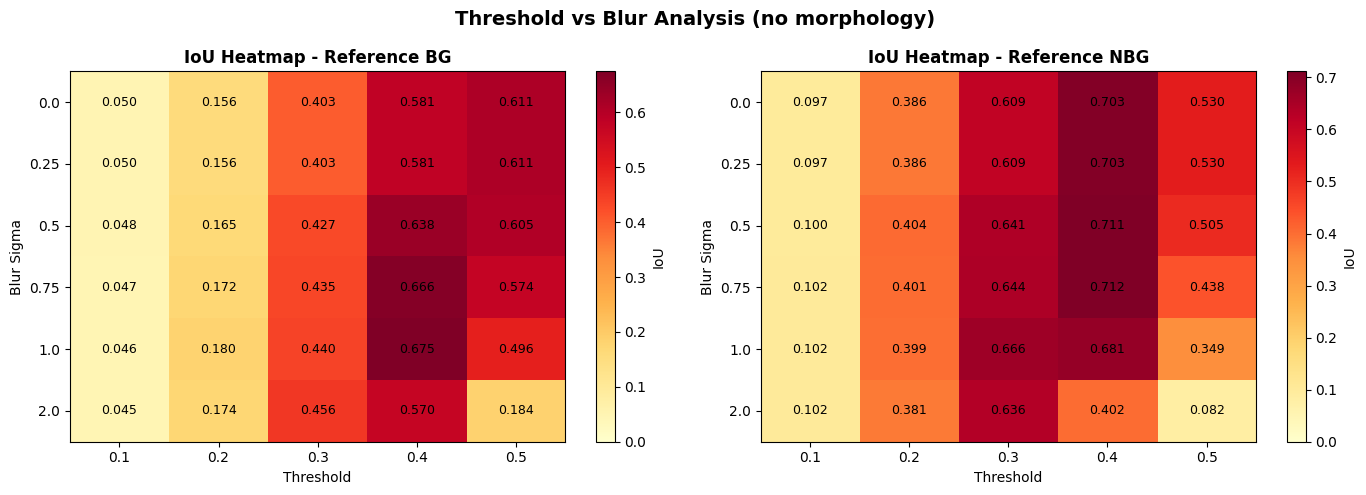

In [ ]:
# Heatmap: Threshold vs Blur for each Reference type

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, ref_type in enumerate(['BG', 'NBG']):
    ax = axes[idx]
    
    # Filter and pivot
    df_ref = df[(df['reference'] == ref_type) & (df['morphology'] == 'none')]
    pivot = df_ref.pivot_table(values='iou', index='blur_sigma', columns='threshold')
    
    im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=pivot.values.max())
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f'{t:.1f}' for t in pivot.columns])
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Blur Sigma')
    ax.set_title(f'IoU Heatmap - Reference {ref_type}', fontweight='bold')
    
    # Add values
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            ax.text(j, i, f'{pivot.values[i,j]:.3f}', ha='center', va='center', fontsize=9)
    
    plt.colorbar(im, ax=ax, label='IoU')

plt.suptitle('Threshold vs Blur Analysis (no morphology)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

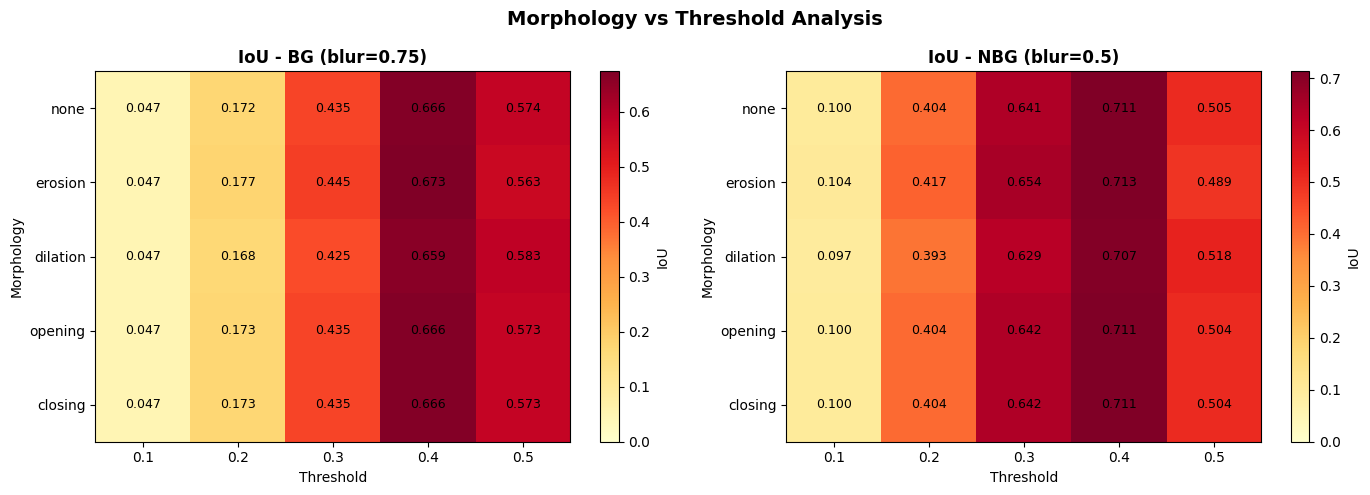

In [ ]:
# Heatmap: Morphology vs Threshold

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, ref_type in enumerate(['BG', 'NBG']):
    ax = axes[idx]
    
    # Filter and pivot (best blur sigma)
    best_blur = df[df['reference'] == ref_type].groupby('blur_sigma')['iou'].mean().idxmax()
    df_ref = df[(df['reference'] == ref_type) & (df['blur_sigma'] == best_blur)]
    pivot = df_ref.pivot_table(values='iou', index='morphology', columns='threshold')
    pivot = pivot.reindex(['none', 'erosion', 'dilation', 'opening', 'closing'])
    
    im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=pivot.values.max())
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f'{t:.1f}' for t in pivot.columns])
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Morphology')
    ax.set_title(f'IoU - {ref_type} (blur={best_blur})', fontweight='bold')
    
    # Add values
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            ax.text(j, i, f'{pivot.values[i,j]:.3f}', ha='center', va='center', fontsize=9)
    
    plt.colorbar(im, ax=ax, label='IoU')

plt.suptitle('Morphology vs Threshold Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

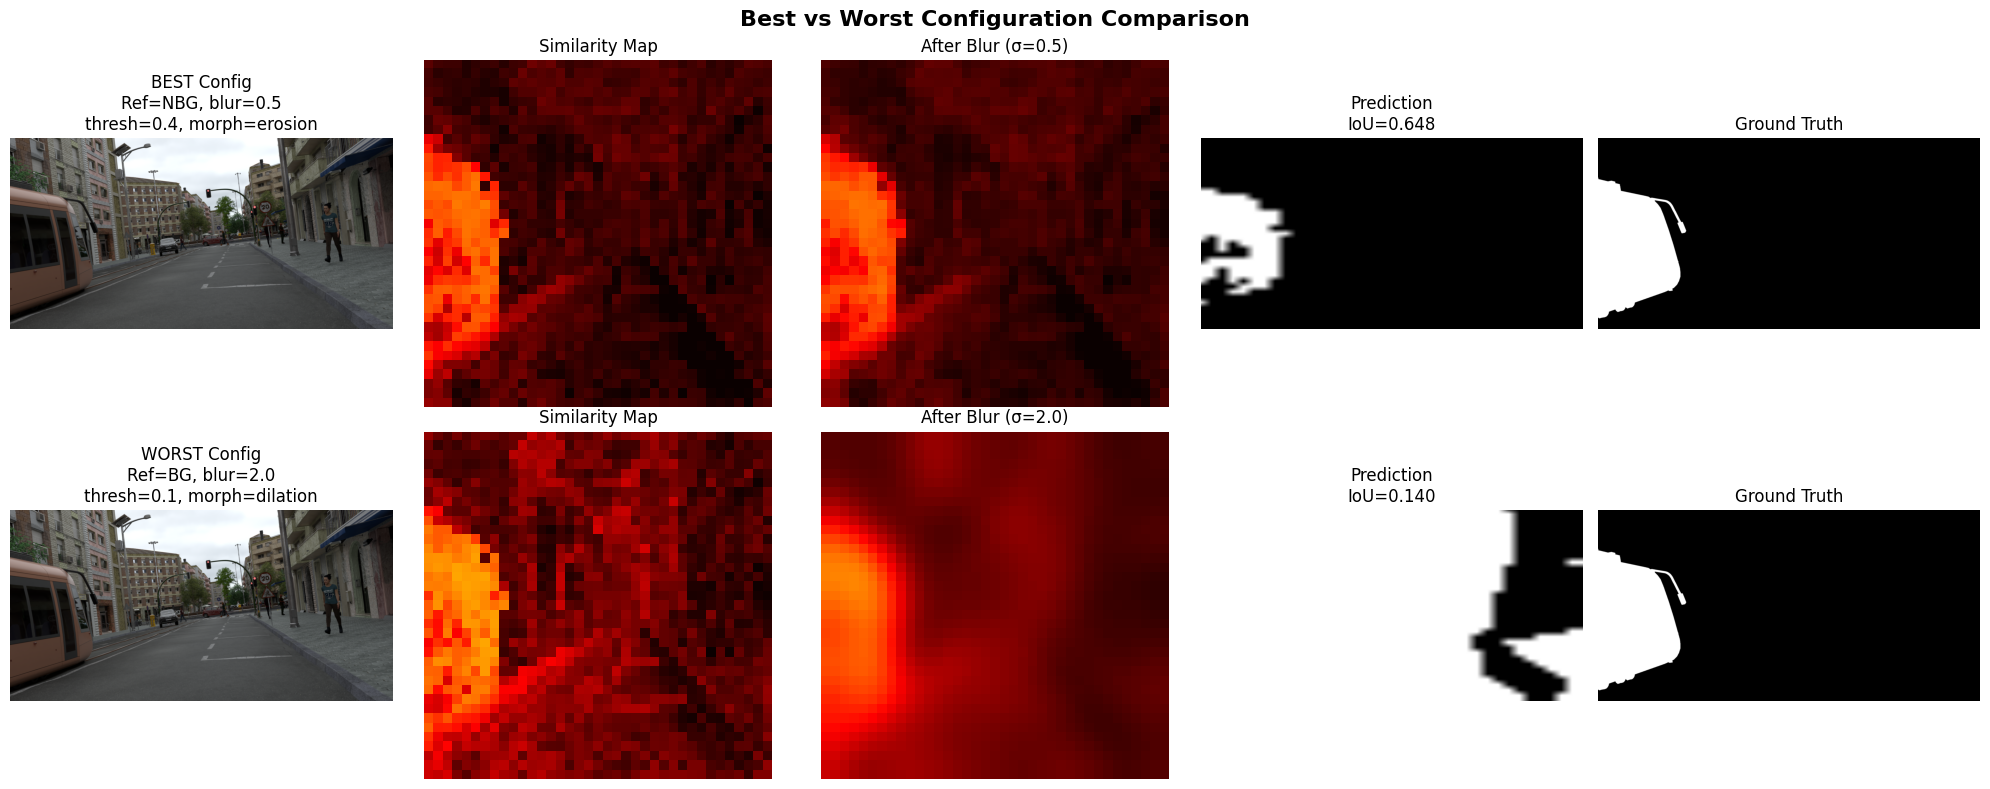

In [ ]:
# Visualize Best vs Worst Configuration

best_config = df_sorted.iloc[0]
worst_config = df_sorted.iloc[-1]

# Pick a sample image
sample_path = list(sim_maps_cache.keys())[0]
cache = sim_maps_cache[sample_path]

def apply_config(sim_map, gt_mask, config):
    sim_blurred = apply_blur(sim_map, config['blur_sigma'])
    pred_small = (sim_blurred >= config['threshold']).astype(np.float32)
    pred = upscale_mask(pred_small, gt_mask.shape)
    pred = apply_morphology(pred, config['morphology'])
    return sim_blurred, pred

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for row, (config, title) in enumerate([(best_config, 'BEST'), (worst_config, 'WORST')]):
    sim_map = cache[config['reference']]
    gt_mask = cache['gt_mask']
    sim_blurred, pred_mask = apply_config(sim_map, gt_mask, config)
    metrics = compute_metrics(pred_mask, gt_mask)
    
    # Original image
    axes[row, 0].imshow(Image.open(sample_path))
    axes[row, 0].set_title(f'{title} Config\nRef={config["reference"]}, blur={config["blur_sigma"]}\nthresh={config["threshold"]}, morph={config["morphology"]}')
    axes[row, 0].axis('off')
    
    # Similarity map
    axes[row, 1].imshow(sim_map, cmap='hot', vmin=0, vmax=1)
    axes[row, 1].set_title('Similarity Map')
    axes[row, 1].axis('off')
    
    # Blurred similarity map
    axes[row, 2].imshow(sim_blurred, cmap='hot', vmin=0, vmax=1)
    axes[row, 2].set_title(f'After Blur (σ={config["blur_sigma"]})')
    axes[row, 2].axis('off')
    
    # Predicted mask
    axes[row, 3].imshow(pred_mask, cmap='gray')
    axes[row, 3].set_title(f'Prediction\nIoU={metrics["iou"]:.3f}')
    axes[row, 3].axis('off')
    
    # Ground truth
    axes[row, 4].imshow(gt_mask, cmap='gray')
    axes[row, 4].set_title('Ground Truth')
    axes[row, 4].axis('off')

plt.suptitle('Best vs Worst Configuration Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Final Summary

print("="*80)
print("SCIENTIFIC BENCHMARK SUMMARY")
print("="*80)
print(f"\nDataset: {len(image_pairs)} images with ground truth car masks")
print(f"Configurations tested: {len(results)}")
print(f"\n" + "-"*80)
print("BEST CONFIGURATION:")
print("-"*80)
best = df_sorted.iloc[0]
print(f"  Reference:      {'WITH' if best['reference']=='BG' else 'WITHOUT'} background ({best['reference']})")
print(f"  Blur Sigma:     {best['blur_sigma']}")
print(f"  Threshold:      {best['threshold']}")
print(f"  Morphology:     {best['morphology']}")
print(f"\n  IoU:            {best['iou']:.4f}")
print(f"  Precision:      {best['precision']:.4f}")
print(f"  Recall:         {best['recall']:.4f}")
print(f"  F1-Score:       {best['f1']:.4f}")

print(f"\n" + "-"*80)
print("KEY FINDINGS:")
print("-"*80)

# Reference comparison
bg_mean = df[df['reference']=='BG']['iou'].mean()
nbg_mean = df[df['reference']=='NBG']['iou'].mean()
winner = 'WITHOUT background (NBG)' if nbg_mean > bg_mean else 'WITH background (BG)'
print(f"  1. Reference: {winner} performs better")
print(f"     BG avg IoU: {bg_mean:.4f}, NBG avg IoU: {nbg_mean:.4f}")

# Best blur
best_blur = df.groupby('blur_sigma')['iou'].mean().idxmax()
print(f"  2. Best blur sigma: {best_blur}")

# Best threshold
best_thresh = df.groupby('threshold')['iou'].mean().idxmax()
print(f"  3. Best threshold: {best_thresh}")

# Best morphology
best_morph = df.groupby('morphology')['iou'].mean().idxmax()
print(f"  4. Best morphology: {best_morph}")

print("="*80)

SCIENTIFIC BENCHMARK SUMMARY

Dataset: 14 images with ground truth car masks
Configurations tested: 300

--------------------------------------------------------------------------------
BEST CONFIGURATION:
--------------------------------------------------------------------------------
  Reference:      WITHOUT background (NBG)
  Blur Sigma:     0.5
  Threshold:      0.4
  Morphology:     erosion

  IoU:            0.7130
  Precision:      0.8121
  Recall:         0.8138
  F1-Score:       0.8030

--------------------------------------------------------------------------------
KEY FINDINGS:
--------------------------------------------------------------------------------
  1. Reference: WITHOUT background (NBG) performs better
     BG avg IoU: 0.3549, NBG avg IoU: 0.4370
  2. Best blur sigma: 0.5
  3. Best threshold: 0.4
  4. Best morphology: erosion


In [ ]:
# Export results to CSV
df_sorted.to_csv('benchmark_results.csv', index=False)
print("Results exported to benchmark_results.csv")

Results exported to benchmark_results.csv


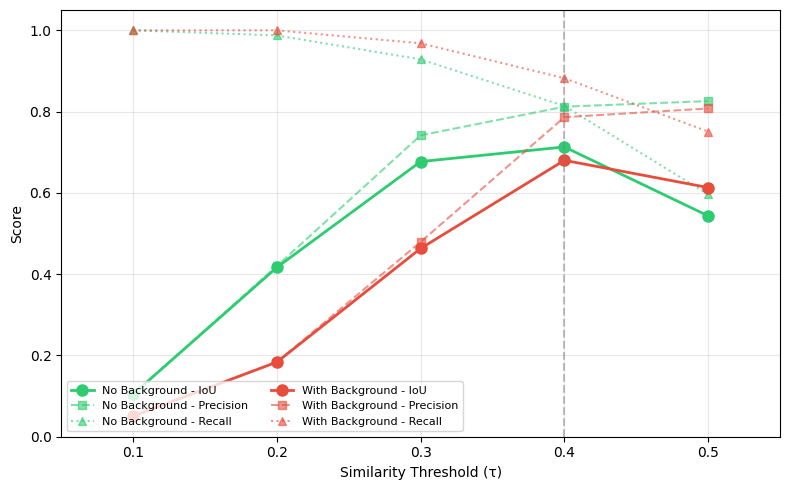

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('benchmark_results.csv')

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []
for ref in ['NBG', 'BG']:
    for thresh in thresholds:
        subset = df[(df['reference'] == ref) & (df['threshold'] == thresh)]
        if len(subset) > 0:
            best_idx = subset['iou'].idxmax()
            best_row = subset.loc[best_idx]
            results.append({
                'reference': ref, 'threshold': thresh,
                'iou': best_row['iou'], 'precision': best_row['precision'],
                'recall': best_row['recall']
            })

results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 5))
colors = {'NBG': '#2ecc71', 'BG': '#e74c3c'}

for ref in ['NBG', 'BG']:
    data = results_df[results_df['reference'] == ref]
    label = 'No Background' if ref == 'NBG' else 'With Background'
    ax.plot(data['threshold'], data['iou'], 'o-', markersize=8, 
            linewidth=2, color=colors[ref], label=f'{label} - IoU')
    ax.plot(data['threshold'], data['precision'], 's--', markersize=6,
            linewidth=1.5, color=colors[ref], alpha=0.6, label=f'{label} - Precision')
    ax.plot(data['threshold'], data['recall'], '^:', markersize=6,
            linewidth=1.5, color=colors[ref], alpha=0.6, label=f'{label} - Recall')

ax.axvline(x=0.4, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Similarity Threshold (τ)')
ax.set_ylabel('Score')
ax.set_xlim(0.05, 0.55)
ax.set_ylim(0, 1.05)
ax.legend(loc='lower left', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()
